# 권철민 강사의 강의인 딥러닝 컴퓨터 비전 완벽 가이드를 복습하기 위해 만든 파일입니다.

## Opencv DNN 패키지를 이용해 Faster R-CNN 기반 이미지의 Object Detection 수행
* tensorflow에서 pretrained 된 모델 파일을 opencv에서 로드해 이미지의 영상에 대한 object detection 수행

#### 입력 이미지로 사용될 이미지 다운로드 및 로드

In [1]:
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

mkdir: cannot create directory ‘/content/data’: File exists
--2024-04-24 11:34:13--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.03s   

2024-04-24 11:34:13 (10.5 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



(633, 806, 3)


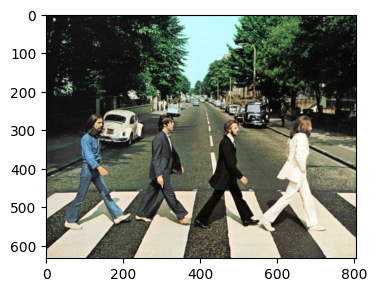

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

img = cv2.imread('/content/data/beatles01.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)
plt.figure(figsize=(4,4))
plt.imshow(img_rgb)

#### tensorflow에서 pretrained된 inference 모델(frozen graph)와 환경파일을 다운로드 받은 후 이를 이용해 opencv에서 inference 모델 생성
* 여기서 frozen graph는 네트워크를 구성하는 weights를 상수화하여 고정시켜 네트워크 아키텍처와 weights를 하나의 파일 안에 합쳐놓은 형상
* https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에서 파일을 받는다

In [3]:
!mkdir /content/pretrained
!wget -O ./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
!wget -O ./pretrained/config_graph.pbtxt https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt

mkdir: cannot create directory ‘/content/pretrained’: File exists
--2024-04-24 11:34:14--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.120.207, 142.251.120.207, 142.251.161.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.120.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381355771 (364M) [application/x-tar]
Saving to: ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’

./pretrained/faster 100%[===================>] 363.69M   113MB/s    in 3.2s    

2024-04-24 11:34:17 (113 MB/s) - ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’ saved [381355771/381355771]

--2024-04-24 11:34:17--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185

In [4]:
!tar -xvf ./pretrained/faster*.tar.gz -C ./pretrained

faster_rcnn_resnet50_coco_2018_01_28/
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.index
faster_rcnn_resnet50_coco_2018_01_28/checkpoint
faster_rcnn_resnet50_coco_2018_01_28/pipeline.config
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.data-00000-of-00001
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.meta
faster_rcnn_resnet50_coco_2018_01_28/saved_model/
faster_rcnn_resnet50_coco_2018_01_28/saved_model/saved_model.pb
faster_rcnn_resnet50_coco_2018_01_28/saved_model/variables/
faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb


In [5]:
!pwd
!ls -lia ./pretrained/faster_rcnn_resnet50_coco_2018_01_28

/content
total 296076
4063330 drwxr-xr-x 3 345018 5000      4096 Feb  1  2018 .
4063325 drwxr-xr-x 3 root   root      4096 Apr 24 10:36 ..
4063331 -rw-r--r-- 1 345018 5000        77 Feb  1  2018 checkpoint
4063339 -rw-r--r-- 1 345018 5000 120549957 Feb  1  2018 frozen_inference_graph.pb
4063333 -rw-r--r-- 1 345018 5000 176914228 Feb  1  2018 model.ckpt.data-00000-of-00001
4063329 -rw-r--r-- 1 345018 5000     14460 Feb  1  2018 model.ckpt.index
4063335 -rw-r--r-- 1 345018 5000   5675175 Feb  1  2018 model.ckpt.meta
4063332 -rw-r--r-- 1 345018 5000      3240 Feb  1  2018 pipeline.config
4063336 drwxr-xr-x 3 345018 5000      4096 Feb  1  2018 saved_model


#### dnn에서 readNetFromTensorflow()로 tensorflow inference 모델을 로딩

In [6]:
# opencv의 dnn 모듈은 순전파와 추론만 지원해서 역전파를 이용한 학습은 불가하다
# opencv dnn 모듈을 활용해서 inference 수행

# parameter로 각각 훈련된 가중치를 이진 파일과
# 네트워크 구성을 저장하고 있는 config 파일 이렇게 2개를 넣어준다.
# 참고로 config 파일은 collection of settings that IntegratedML uses to train a model을 의미한다.

cv_net = cv2.dnn.readNetFromTensorflow('/content/pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb',
                                      '/content/pretrained/config_graph.pbtxt')

#### coco data set의 클래스id별 클래스명 지정

* 클래스 id와 name의 mapping 벙삭이 모델마다 조금씩 달라 주의가 필요.



In [7]:
# OpenCV Yolo용
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

In [8]:
# OpenCV Tensorflow Faster-RCNN용
labels_to_names_0 = {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}

In [9]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}


#### 이미지를 preprocessing을 수행하여 network에 입력하고 object detection 수행 후 결과를 이미지에 시각화

In [10]:
img.shape

(633, 806, 3)

(1, 1, 100, 7)
person: 0.9998
person: 0.9996
person: 0.9993
person: 0.9970
person: 0.8995
car: 0.8922
car: 0.7602
car: 0.7415
car: 0.6929
car: 0.6918
car: 0.6896
car: 0.6717
car: 0.6521
car: 0.5730
car: 0.5679
car: 0.5261
car: 0.5012


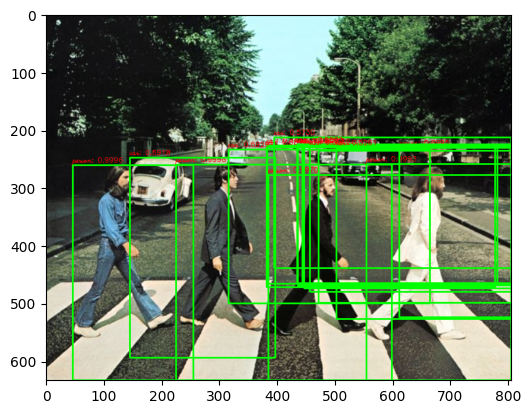

In [11]:
# 원본 이미지가 Faster RCNN 기반 네트웍으로 입력 시 resize된다
# scaling된 이미지 기반으로 bounding box 위치가 계속 예측되므로 이를 다시 복구하기 위해 원본 이미지 shape 필요
rows = img.shape[0]
cols = img.shape[1]

draw_img = img.copy()

# 원본 이미지 배열 BGR을 RGB로 변환하여 배열 입력
# Tensorflow Fater RCNN은 마지막 classification layer가 dense가 아니라 size를 고정할 필요는 없다
# opencv dnn 모듈에 이미지를 넣기 위해선 blobFromImage를 통해 입력 데이터를 blob 객체로 만들어야 함
# blobFromImage에 넣어서 나온 값의 shape는 (1, 3, 33, 806)인데 (이미지 개수, 채널 수, 영상 높이, 영상 너비 의미)
cv_net.setInput(cv2.dnn.blobFromImage(img, swapRB=True, crop=False))

# object detection 수행하여 결과를 cvOut으로 반환
# forward를 통한 순방향 진행을 통해 추론 수행
cv_out = cv_net.forward()

'''
cv_out.shape 결과로 (1, 1, 100, 7) 출력

앞에 1,1은 특별한 의미는 없다
cv_out.shape[2]는 detect된 object 개수가 100게라는 뜻이다
cv_out.shape[3]에서 0번 인덱스는 의미 없는 0이고 나머지는 각각 클래스id, 확신정도, 좌상단 후하단 xy값
'''

print(cv_out.shape)

# bounding box의 테두리와 caption 글자색 지정
green_color = (0, 255, 0)
red_color = (0, 0, 255)

# detected된 object들을 iteration하면서 정보 추출
# 위에서 object로 추정되는 것들을 100개 찾았으니 100번 루프
for detection in cv_out[0,0,:,:]:
  class_id = int(detection[1])  # class_id는 해당 id와 name을 연결한 dictionary 활용을 위해 int로 변환
  score = float(detection[2])
  # detected된 object들의 score 하한선을 둬서 양 줄이기
  if score > 0.5:
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    left = detection[3] * cols
    top = detection[4] * rows
    right = detection[5] * cols
    bottom = detection[6] * rows
    # labels_to_names_seq 딕셔너리로 class id 값을 이름으로 변경
    caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
    print(caption)
    # cv2.rectangle()로 draw_img에 사각형을 그리는데 위치 인자는 반드시 int()형으로
    cv2.rectangle(draw_img, (int(left), int(top), int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 0.4, red_color, 1)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img_rgb)

#### 단일 이미지의 object detection 함수로 생성

In [12]:
from os import spawnlp
import time

def get_detected_img(cv_net, img_array, score_threshold, use_copied_array=True, is_print=True):

  rows = img_array.shape[0]
  cols = img_array.shape[1]

  draw_img = None
  if use_copied_array:
    draw_img = img_array.copy()
  else:
    draw_img = img_array

  cv_net.setInput(cv2.dnn.blobFromImage(draw_img, swapRB=True, crop=False))

  start = time.time()
  cv_out = cv_net.forward()

  green_color = (0, 255, 0)
  red_color = (0, 0, 255)

  # detected 된 obejct들을 iteration하면서 정보 추출
  for detection in cv_out[0,0,:,:]:
    class_id = int(detection[1])
    score = float(detection[2])
    # detected 된 object들의 score가 함수 인자로 들어온 score_threshold 이상만 추출
    if score > score_threshold:
      # 원본 비율로 복원
      left = detection[3] * cols
      top = detection[4] * rows
      right = detection[5] * cols
      bottom = detection[6] * rows
      # labels to name 딕셔너리로 class_id 값을 클래스명으로 변경
      caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
      print(caption)
      # cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형
      cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
      cv2.putText(draw_img, caption, (int(left), int(top-5)), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 0.4, red_color,1)

  if is_print:
    print("detection 수행시간:", round(time.time() - start, 2), "초")

  return draw_img

image shape: (633, 806, 3)
person: 0.9998
person: 0.9996
person: 0.9993
person: 0.9970
person: 0.8995
car: 0.8922
car: 0.7602
car: 0.7415
car: 0.6929
car: 0.6918
car: 0.6896
car: 0.6717
car: 0.6521
car: 0.5730
car: 0.5679
car: 0.5261
car: 0.5012
detection 수행시간: 6.56 초


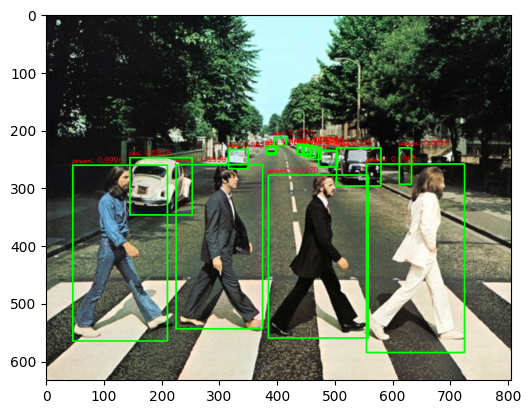

In [13]:
# image 로드
img = cv2.imread('./data/beatles01.jpg')
print('image shape:', img.shape)

# tensorflow inference 모델 로딩
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb',
                                     './pretrained/config_graph.pbtxt')
# Object Detetion 수행 후 시각화
draw_img = get_detected_img(cv_net, img, score_threshold=0.5, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)

## Video Object Detection 수행

#### 원본 영상

In [14]:
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2024-04-24 11:35:00--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2024-04-24 11:35:00--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2024-04-24 11:35:01--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.

#### VideoCapture와 VideoWriter 설정하기
* VideoCapture를 video를 frame별로 작업
* VideoCapture의 속성을 이용해 video frame 크기 및 FPS 설정
* VideoWriter를 위한 인코딩 코덱 설정 및 영상 write를 위한 설정
* VideoCapture는 Video Streaming을 frame 단위로 capture하여 처리
* VideoWriter 객체는 VideoCapture로 읽어들인 Frame을 동영상으로 저장하는 기능 제공

In [15]:
video_input_path = '/content/data/Jonh_Wick_small.mp4'
video_output_path = '/content/data/Jonh_Wick_small_cv01.mp4'

cap = cv2.VideoCapture(video_input_path)  # 여기서 영상을 받아오고

codec = cv2.VideoWriter_fourcc(*'XVID')

vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
vid_fps = cap.get(cv2.CAP_PROP_FPS)

vid_writer = cv2.VideoWriter(video_output_path, codec, vid_fps, vid_size)  # 여기서 영상을 저장

frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("total frame count: ", frame_cnt)

cv_net = cv2.dnn.readNetFromTensorflow('/content/pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb',
                                       '/content/pretrained/config_graph.pbtxt')

total frame count:  58


#### frame 단위로 iteration하면서 obejct detection 수행한다.
* 결국 개별 frame 별로 object detection을 하는거라 단일 이미지에서 하던 방식이랑 유사하다.

In [16]:
green_color = (0, 255, 0)
red_color = (0, 0, 255)

while True:

  # cap.read()로 프레임을 하나씩 읽는데 hasFrame은 다음 frame 존재유무
  # 다음에 읽을 frame이 없으면 hasFrame은 False
  hasFrame, img_frame = cap.read()
  if not hasFrame:
    print('더 이상 처리할 frame이 없습니다')
    break

  rows = img_frame.shape[0]
  cols = img_frame.shape[1]
  # 원본 이미지 배열 BGR을 RGB로 변환하여 배열 입력
  cv_net.setInput(cv2.dnn.blobFromImage(img_frame, swapRB=True, crop=False))

  start = time.time()
  # 결과를 cv_out으로 넘긴다
  cv_out = cv_net.forward()
  frame_index = 0
  # detected된 object들을 iteration하면서 정보 추출
  for detection in cv_out[0,0,:,:]:
    class_id = int(detection[1])
    score = float(detection[2])
    # detected된 object들 중에서 정확도 0.5 이상만 추출
    if score > 0.5:
      left = detection[3] * cols
      top = detection[4] * rows
      right = detection[5] * cols
      bottom = detection[6] * rows
      # labels_to_names_0 딕셔너리로 class_id 값을 클래스명으로 변경.
      caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
      # cv2.rectangle() 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형
      cv2.rectangle(img_frame, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
      cv2.putText(img_frame, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)
  print('수행시간: ', round(time.time()-start, 2),"초")

  # cv2.VideoWriter().write를 통해서 저장
  vid_writer.write(img_frame)

vid_writer.release()
cap.release()

수행시간:  6.65 초
수행시간:  6.71 초
수행시간:  5.59 초
수행시간:  6.27 초
수행시간:  6.53 초
수행시간:  6.02 초
수행시간:  6.7 초
수행시간:  5.75 초
수행시간:  6.84 초
수행시간:  5.99 초
수행시간:  7.01 초
수행시간:  5.68 초
수행시간:  6.99 초
수행시간:  5.65 초
수행시간:  6.99 초
수행시간:  5.86 초
수행시간:  6.63 초
수행시간:  5.69 초
수행시간:  6.22 초
수행시간:  6.81 초
수행시간:  6.33 초
수행시간:  5.88 초
수행시간:  6.7 초
수행시간:  6.31 초
수행시간:  6.1 초
수행시간:  6.55 초
수행시간:  5.71 초
수행시간:  6.68 초
수행시간:  5.73 초
수행시간:  6.76 초
수행시간:  5.38 초
수행시간:  7.11 초
수행시간:  5.36 초
수행시간:  7.33 초
수행시간:  5.68 초
수행시간:  6.32 초
수행시간:  6.2 초
수행시간:  6.02 초
수행시간:  7.5 초
수행시간:  7.44 초
수행시간:  6.14 초
수행시간:  5.87 초
수행시간:  6.69 초
수행시간:  5.98 초
수행시간:  6.4 초
수행시간:  5.63 초
수행시간:  6.87 초
수행시간:  6.49 초
수행시간:  7.32 초
수행시간:  5.65 초
수행시간:  6.85 초
수행시간:  5.53 초
수행시간:  7.16 초
수행시간:  5.7 초
수행시간:  6.45 초
수행시간:  5.79 초
수행시간:  6.02 초
수행시간:  6.57 초
더 이상 처리할 frame이 없습니다


In [19]:
def do_detected_video(cv_net, input_path, output_path, score_threshold, is_print):

  cap = cv2.VideoCapture(input_path)
  codec = cv2.VideoWriter_fourcc(*'XVID')

  vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
  vid_fps = cap.get(cv2.CAP_PROP_FPS)

  vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

  frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print("total frame: ", frame_cnt)

  green_color = (0, 255, 0)
  red_color = (0, 0, 255)
  while True:
    hasFrame, img_frame = cap.read()
    if not hasFrame:
      print("다음 프레임 없음")
      break

    img_frame = get_detected_img(cv_net, img_frame, score_threshold, False, is_print)

    vid_writer.write(img_frame)

  vid_writer.release()
  cap.release()


In [20]:
do_detected_video(cv_net, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_02.mp4', 0.5, False)

total frame:  58
car: 0.9882
car: 0.9622
person: 0.9495
car: 0.9266
car: 0.8772
motorcycle: 0.6607
car: 0.9881
car: 0.9643
person: 0.9581
car: 0.9318
car: 0.8992
motorcycle: 0.5682
car: 0.9903
car: 0.9833
motorcycle: 0.9532
car: 0.9115
car: 0.8625
person: 0.7814
person: 0.5169
car: 0.9919
car: 0.9909
car: 0.9870
motorcycle: 0.8655
person: 0.7585
person: 0.7484
person: 0.7375
car: 0.7361
person: 0.7200
car: 0.6120
car: 0.9933
car: 0.9817
motorcycle: 0.9781
car: 0.9530
car: 0.7823
person: 0.5313
car: 0.9799
car: 0.9678
car: 0.9496
person: 0.8299
car: 0.6521
motorcycle: 0.6003
car: 0.9809
car: 0.9647
car: 0.9632
person: 0.8467
car: 0.7496
car: 0.6391
motorcycle: 0.5894
person: 0.5808
car: 0.9844
motorcycle: 0.9825
car: 0.9683
car: 0.9670
car: 0.5693
car: 0.9877
car: 0.9737
car: 0.9403
car: 0.9125
motorcycle: 0.8699
person: 0.6535
car: 0.9902
car: 0.9878
car: 0.9599
motorcycle: 0.9435
car: 0.7138
person: 0.5800
cup: 0.5553
car: 0.9907
car: 0.9776
motorcycle: 0.9524
car: 0.8853
person: 0.81